In [40]:
# import required modules
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import statistics
from collections import Counter
import matplotlib.dates as mdates

In [41]:
# import table
mm = pd.read_csv('../data_tables/metadataMatrix_filtered.csv')
mm

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,total_use_count,reuse_role,pub_delay
0,eLife,PMC5630260,GSE89436,GSE89436,GEO,2017-09-27 00:00:00,2017-03-31 00:00:00,Mus musculus,NaN,NaN,NaN,NaN,NaN,1,G,180.0
1,PLoS_Genet,PMC4633059,GSE62152,GSE62152,GEO,2015-11-04 00:00:00,2015-05-08 00:00:00,Mycobacterium tuberculosis,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,1,G,180.0
2,Front_Microbiol,PMC5030273,SRP072068,SRP072068,SRA,2016-09-21 00:00:00,2016-03-25 00:00:00,insect gut metagenome,Illumina MiSeq,WGS,500.0,1.238730e+08,public,1,G,180.0
3,Heliyon,PMC5968172,SRR6186127,SRP120276,SRA,2018-04-16 00:00:00,2017-10-18 00:00:00,subsurface metagenome,454 GS FLX+,AMPLICON,973.0,2.965432e+07,public,1,G,180.0
4,ISME_J,PMC6776055,PRJNA506462,SRP170418,SRA,2019-05-30 00:00:00,2018-12-01 00:00:00,wastewater metagenome,Illumina HiSeq 4000,Hi-C,302.0,2.877598e+10,public,1,G,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161810,Saudi_J_Biol_Sci,PMC5851940,GSM107072,GSE1456,GEO,2017-11-20,2006-05-31,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,270,R,NaN
161811,Saudi_J_Biol_Sci,PMC5851940,GSM107231,GSE1456,GEO,2017-11-20,2006-05-31,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,270,R,NaN
161812,Saudi_J_Biol_Sci,PMC6088103,GSE29378,GSE29378,GEO,2018-05-18,2013-06-07,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,16,R,NaN
161813,Saudi_J_Biol_Sci,PMC6088103,GSE28146,GSE28146,GEO,2018-05-18,2011-08-01,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,33,R,NaN


# Look at each DATASET:

In [42]:
# how many times is each dataset used?
# take the slice we need from mm
accs = mm[['converted_accession', 'repository', 'total_use_count']].drop_duplicates()
accs['reuse_count'] = accs['total_use_count'] - 1
accs

,converted_accession,repository,total_use_count,reuse_count
0,GSE89436,GEO,1,0
1,GSE62152,GEO,1,0
2,SRP072068,SRA,1,0
3,SRP120276,SRA,1,0
4,SRP170418,SRA,1,0
...,...,...,...,...
161695,GSE19147,GEO,2,1
161711,ERP109094,SRA,2,1
161757,GSE123413,GEO,2,1
161779,GSE18081,GEO,2,1


In [43]:
# what percentage of datasets are used more than once (re-used at least once)?
accs['wasReused'] = accs['reuse_count'] >= 1
accsPcts = accs.groupby('repository', as_index = False).agg({'wasReused':'mean'})
accsPcts = accsPcts.rename(columns = {'wasReused':'pctReused'})
accsPcts

,repository,pctReused
0,GEO,0.416554
1,SRA,0.301706


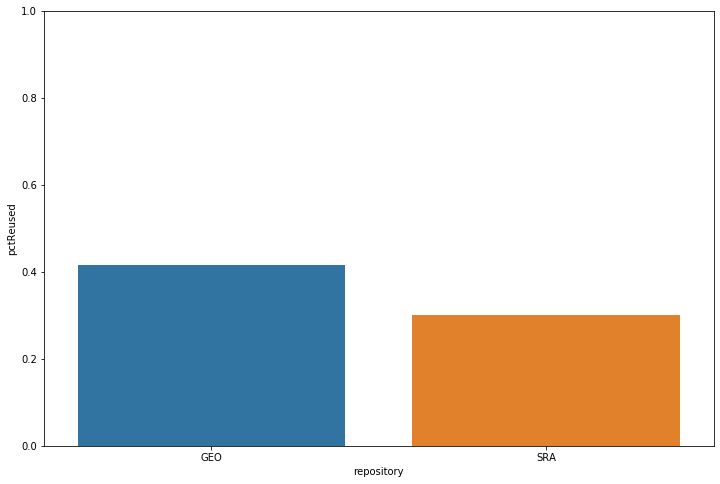

In [44]:
fig_dims = (12,8)

# plot barplot showing percentage of datasets reused in GEO and SRA
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = accsPcts, x = 'repository', y = 'pctReused', ax = ax)
plt.ylim(0,1)
plt.show()

[None]

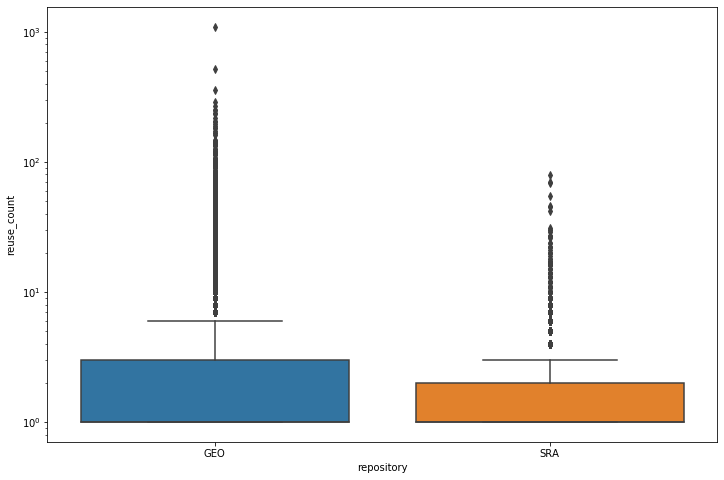

In [45]:
# plot distribution of use for each unique dataset, first using a boxplot
# each point is a dataset

# remove datasets not reused at all
accs_filt = accs.loc[accs['reuse_count'] >= 1, :]


fig, ax = plt.subplots(figsize=fig_dims)
datasets_box = sns.boxplot(data = accs_filt, x = 'repository', y = 'reuse_count', ax = ax)
datasets_box.set(yscale = 'log')

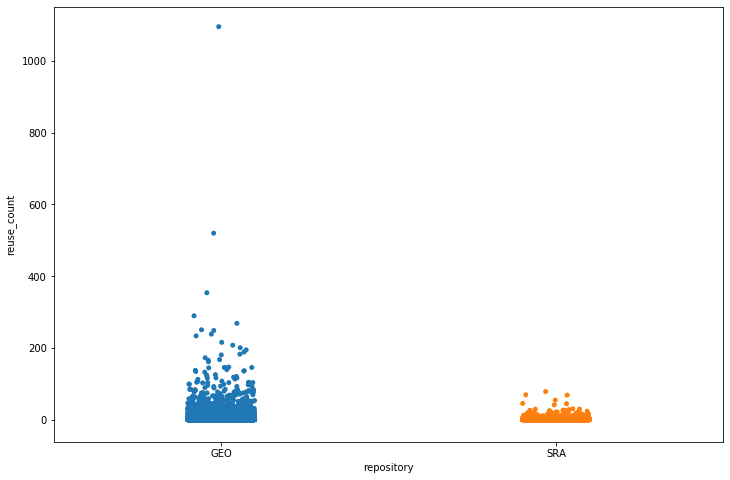

In [46]:
# visualize reuse distribution with a strip plot (jitter plot)
fig, ax = plt.subplots(figsize=fig_dims)
datasets_strip = sns.stripplot(data = accs_filt, x = 'repository', y = 'reuse_count', ax = ax)
# datasets_strip.set(yscale = 'log')

visualize reuse distribution with a histogram


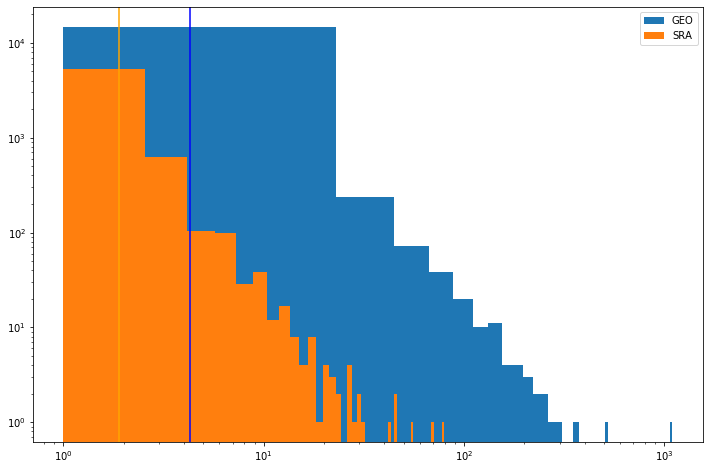

t-statistic = 18.316395792214326
p-value = 3.031440738563159e-74


In [72]:
#visualize reuse distribution with a histogram

print("visualize reuse distribution with a histogram")

geodist = accs_filt['reuse_count'].loc[accs_filt['repository'] == 'GEO']
sradist = accs_filt['reuse_count'].loc[accs_filt['repository'] == 'SRA']

n_bins = 50
fig, ax = plt.subplots(figsize=fig_dims)
geo_hist = ax.hist(geodist, bins = n_bins, label = "GEO")
sra_hist = ax.hist(sradist, bins = n_bins, label = "SRA")
plt.axvline(x = statistics.mean(geodist), color='blue')
plt.axvline(x = statistics.mean(sradist), color='orange')
ax.set(xscale = 'log')
ax.set(yscale = 'log')
ax.legend()
plt.show()

ttest = scipy.stats.ttest_ind(a = geodist, b = sradist, equal_var = False)

# print(statistics.mean(geodist))
print("t-statistic = " + str(ttest[0]))
print("p-value = " + str(ttest[1]))

In [8]:
# define mode function for a list of items with two possible values...
# ...based on which is mentioned more, or 'Both' if score is equal
def getMode(items):
    try:
        r = statistics.mode(items)
    except:
        r = 'Both'
    return r

# Look at each PAPER:

In [9]:
paps = mm[['pmc_ID', 'repository', 'reuse_role', 'pmc_date']]
paps = paps.groupby(['pmc_ID'], as_index = False).agg({'repository': lambda x: getMode(x), 
                                                       'reuse_role': lambda r: getMode(r),
                                                       'pmc_date': lambda d: max(d)})
paps

,pmc_ID,repository,reuse_role,pmc_date
0,PMC1059451,GEO,G,2005-03-08 00:00:00
1,PMC1079818,GEO,G,2005-03-05 00:00:00
2,PMC1082884,GEO,R,2005-03-22
3,PMC1088941,GEO,G,2005-02-14 00:00:00
4,PMC1088946,GEO,G,2005-02-28 00:00:00
...,...,...,...,...
64413,PMC7191965,GEO,R,2020-02-14
64414,PMC7192215,GEO,R,2020-04-07
64415,PMC7193132,GEO,R,2020-03-15
64416,PMC7196449,GEO,R,2020-02-10


In [10]:
# how many papers are in GEO, SRA, or both?
rc = Counter(paps['repository'])
repoCounts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
repoCounts.columns = ['repository', 'count']
repoCounts['percent'] = repoCounts['count'] / repoCounts['count'].sum()
repoCounts

,repository,count,percent
0,GEO,43280,0.671862
1,SRA,20476,0.317861
2,Both,662,0.010277


(0, 1)

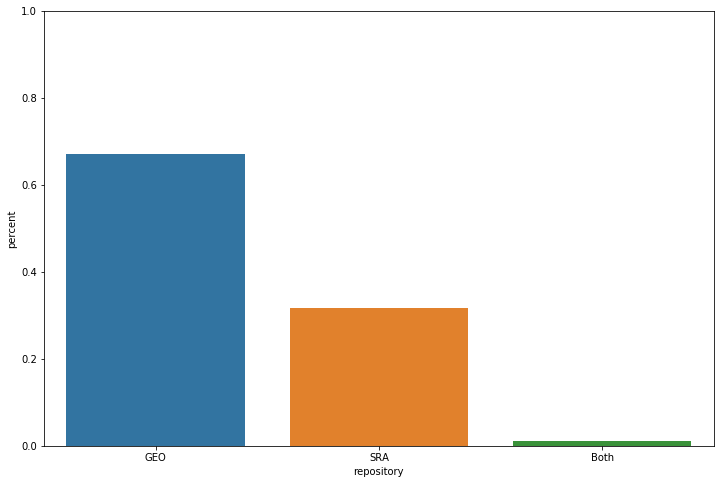

In [11]:
# # visualize distribution of repositories mentioned by papers

# squarefig_dims = (8, 8)
# fig1, ax1 = plt.subplots(figsize = squarefig_dims)
# ax1.pie(repoCounts['count'], labels = repoCounts['repository'])
# ax1.axis('equal')
# plt.show()
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = repoCounts, x = 'repository', y = 'percent', ax = ax)
plt.ylim(0,1)

In [12]:
# how many papers reuse, generate, or both?
recGEO = Counter(paps.loc[paps['repository'] == 'GEO', :]['reuse_role'])
reuseCountsGEO = pd.DataFrame.from_dict(recGEO, orient = 'index').reset_index()
reuseCountsGEO.columns = ['reuse_role', 'count']
reuseCountsGEO['percent'] = reuseCountsGEO['count'] / reuseCountsGEO['count'].sum()
reuseCountsGEO

,reuse_role,count,percent
0,G,20101,0.464441
1,R,21339,0.493045
2,Both,1840,0.042514


In [13]:
# how many papers reuse, generate, or both?
recSRA = Counter(paps.loc[paps['repository'] == 'SRA', :]['reuse_role'])
reuseCountsSRA = pd.DataFrame.from_dict(recSRA, orient = 'index').reset_index()
reuseCountsSRA.columns = ['reuse_role', 'count']
reuseCountsSRA['percent'] = reuseCountsSRA['count'] / reuseCountsSRA['count'].sum()
reuseCountsSRA

,reuse_role,count,percent
0,G,13696,0.668881
1,R,6375,0.311340
2,Both,405,0.019779


GEO
SRA


(0, 1)

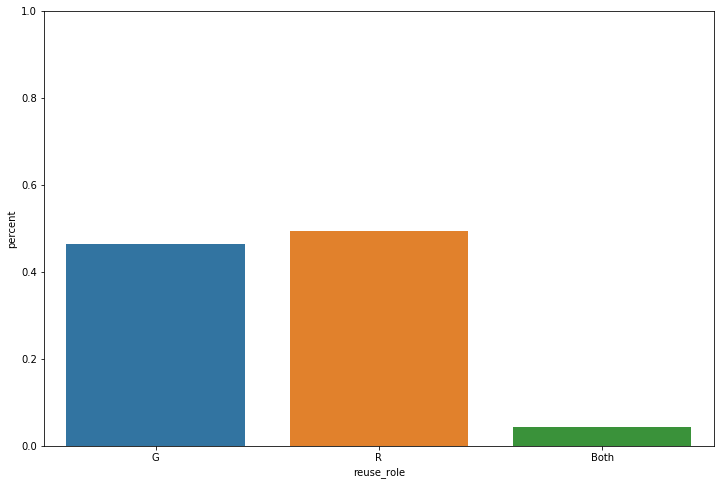

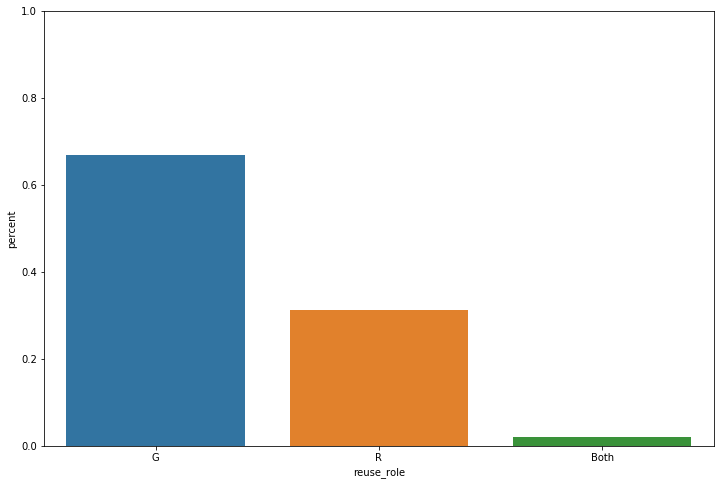

In [14]:
# # visualize reuse distribution

# fig2, ax2 = plt.subplots(figsize = squarefig_dims)
# ax2.pie(reuseCountsGEO['count'], labels = reuseCountsGEO['reuse_role'])
# ax2.axis('equal')
# plt.show()

print('GEO')
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = reuseCountsGEO, x = 'reuse_role', y = 'percent', ax = ax)
plt.ylim(0,1)
# plt.show()

# fig3, ax3 = plt.subplots(figsize = squarefig_dims)
# ax3.pie(reuseCountsSRA['count'], labels = reuseCountsSRA['reuse_role'])
# ax3.axis('equal')
# plt.show()

print('SRA')
fig2, ax2 = plt.subplots(figsize=fig_dims)
sns.barplot(data = reuseCountsSRA, x = 'reuse_role', y = 'percent', ax = ax2)
plt.ylim(0,1)
# plt.show()

In [15]:
paps.loc[paps['pmc_date'] == 'Both']

,pmc_ID,repository,reuse_role,pmc_date


In [16]:
# visualize reuse and repository distribution across the years
# add year column
fmt = '%Y-%m-%d'
paps.loc[:,'pmc_date'] = pd.to_datetime(paps['pmc_date'], format = fmt)
# paps['year'] = paps['pmc_date'].dt.year
paps

,pmc_ID,repository,reuse_role,pmc_date
0,PMC1059451,GEO,G,2005-03-08
1,PMC1079818,GEO,G,2005-03-05
2,PMC1082884,GEO,R,2005-03-22
3,PMC1088941,GEO,G,2005-02-14
4,PMC1088946,GEO,G,2005-02-28
...,...,...,...,...
64413,PMC7191965,GEO,R,2020-02-14
64414,PMC7192215,GEO,R,2020-04-07
64415,PMC7193132,GEO,R,2020-03-15
64416,PMC7196449,GEO,R,2020-02-10


In [17]:
# get repository counts per date
repo_byDate = paps.groupby(['pmc_date', 'repository'])['repository'].count().to_frame(name = 'repo_count').reset_index()

# get reuse counts per date
reuse_byDate = paps.groupby(['pmc_date', 'reuse_role'])['reuse_role'].count().to_frame(name = 'reuse_count').reset_index()

# merge reuse and repository tables
by_date = pd.merge(repo_byDate, reuse_byDate, on = 'pmc_date', how = 'outer')
by_date

,pmc_date,repository,repo_count,reuse_role,reuse_count
0,2002-03-14,GEO,1,G,1
1,2002-06-14,GEO,1,G,1
2,2002-08-29,GEO,1,G,1
3,2002-08-30,GEO,1,G,1
4,2002-10-21,GEO,1,G,1
...,...,...,...,...,...
17136,2020-04-28,SRA,3,R,7
17137,2020-04-29,GEO,4,R,8
17138,2020-04-29,SRA,4,R,8
17139,2020-04-30,GEO,2,R,2


/Users/niko/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


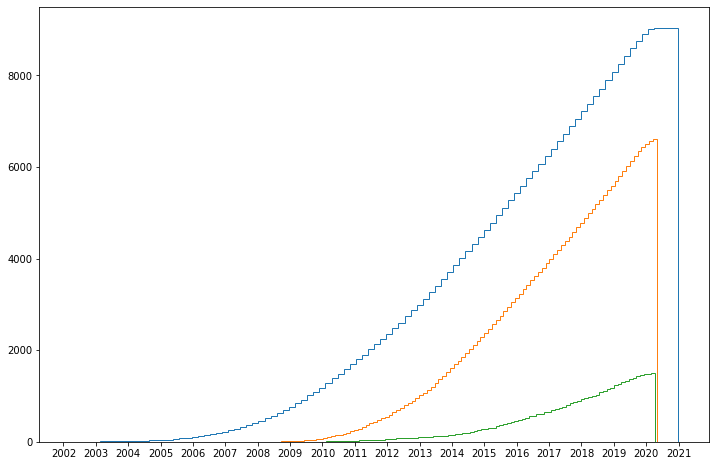

In [18]:
# plot cumulative distribution of papers mentioning each repository each year

geo_byDate = by_date.loc[by_date['repository'] == 'GEO', :]
sra_byDate = by_date.loc[by_date['repository'] == 'SRA', :]
bothRepo_byDate = by_date.loc[by_date['repository'] == 'Both', :]

n_bins = 100 # what makes sense for this?

fig, ax = plt.subplots(figsize=fig_dims)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.hist(geo_byDate['pmc_date'], bins = n_bins, cumulative = True, histtype = 'step')
ax.hist(sra_byDate['pmc_date'], bins = n_bins, cumulative = True, histtype = 'step')
ax.hist(bothRepo_byDate['pmc_date'], bins = n_bins, cumulative = True, histtype = 'step')
plt.show()

GEO


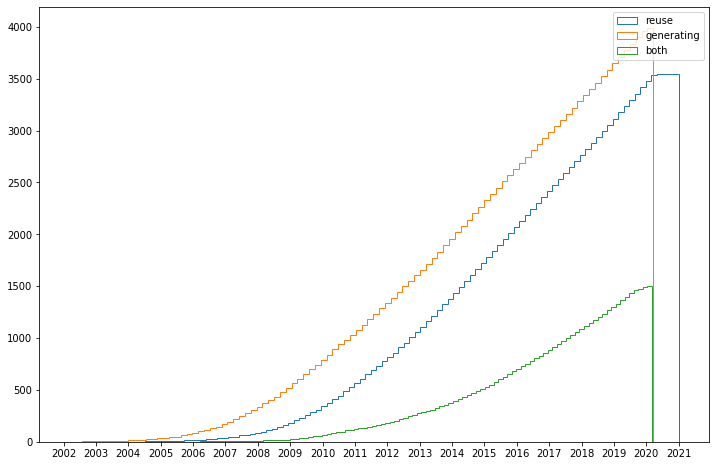

SRA


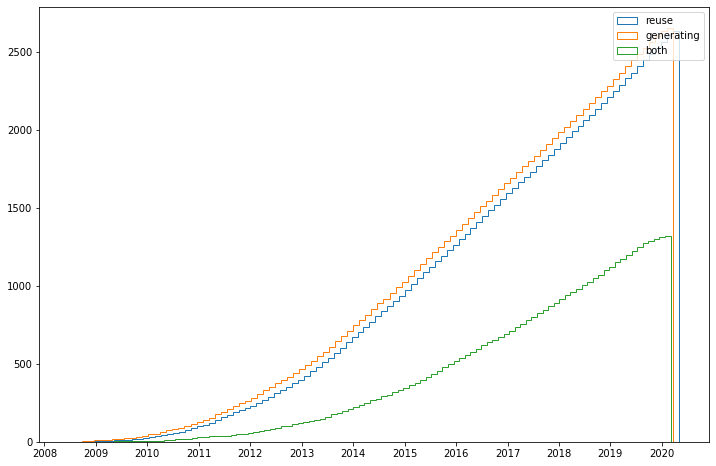

In [73]:
# plot cumulative reuse distribution over the years

n_bins = 100 # what makes sense for this?

for rep in ['GEO', 'SRA']:
    R_byDate = by_date.loc[by_date['reuse_role'] == 'R', :].loc[by_date['repository'] == rep, :]
    G_byDate = by_date.loc[by_date['reuse_role'] == 'G', :].loc[by_date['repository'] == rep, :]
    bothReuse_byDate = by_date.loc[by_date['reuse_role'] == 'Both', :].loc[by_date['repository'] == rep, :]

    fig, ax = plt.subplots(figsize=fig_dims)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.hist(R_byDate['pmc_date'], bins = n_bins, cumulative = True, histtype = 'step', label = 'reuse')
    ax.hist(G_byDate['pmc_date'], bins = n_bins, cumulative = True, histtype = 'step', label = 'generating')
    ax.hist(bothReuse_byDate['pmc_date'], bins = n_bins, cumulative = True, histtype = 'step', label = 'both')
    ax.legend()
    
    print(rep)
    plt.show()

In [20]:
# remove papers with 'Both' listed for either repository or reuse_role
paps = paps.loc[paps['repository'] != 'Both', :].loc[paps['reuse_role'] != 'Both', :]
paps

,pmc_ID,repository,reuse_role,pmc_date
0,PMC1059451,GEO,G,2005-03-08
1,PMC1079818,GEO,G,2005-03-05
2,PMC1082884,GEO,R,2005-03-22
3,PMC1088941,GEO,G,2005-02-14
4,PMC1088946,GEO,G,2005-02-28
...,...,...,...,...
64413,PMC7191965,GEO,R,2020-02-14
64414,PMC7192215,GEO,R,2020-04-07
64415,PMC7193132,GEO,R,2020-03-15
64416,PMC7196449,GEO,R,2020-02-10


In [21]:
# across GEO and SRA, what percentage of papers reuse data?
reuse_pcts = paps.copy()
reuse_pcts['is_reuser'] = (reuse_pcts['reuse_role'] == 'R')

reuse_pcts = reuse_pcts.groupby('repository', as_index = False).agg({'is_reuser' : 'mean'})
reuse_pcts = reuse_pcts.rename(columns = {'is_reuser':'pctReusing'})
reuse_pcts

,repository,pctReusing
0,GEO,0.514937
1,SRA,0.317622


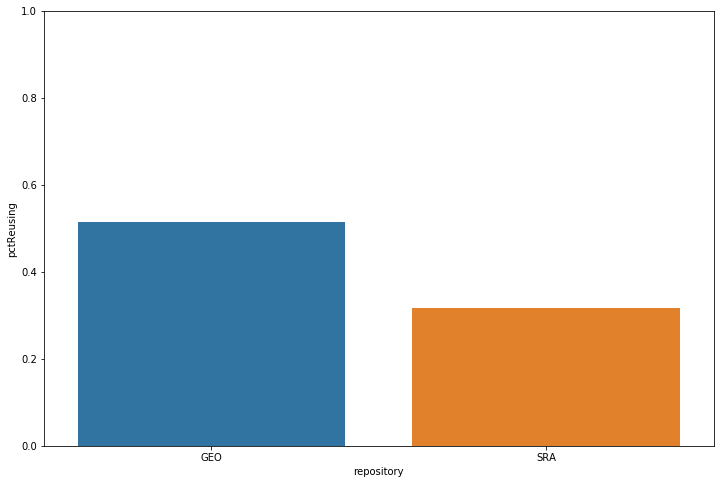

In [22]:
# plot percentage of papers mentioning each repository that reuse data
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = reuse_pcts, x = 'repository', y = 'pctReusing', ax = ax)
plt.ylim(0,1)
plt.show()

# Look at each FEATURE:

In [23]:
mm_filt = pd.merge(paps, mm, how = 'left', on = ['pmc_ID', 'repository', 'reuse_role'])
mm_filt

,pmc_ID,repository,reuse_role,pmc_date_x,journal,accession,converted_accession,pmc_date_y,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,total_use_count,pub_delay
0,PMC1059451,GEO,G,2005-03-08,PLoS_Biol,GSE2227,GSE2227,2005-03-08 00:00:00,2005-02-03 00:00:00,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2,33.0
1,PMC1079818,GEO,G,2005-03-05,BMC_Genomics,GSM34768,GSE1939,2005-03-05 00:00:00,2005-03-15 00:00:00,Mus musculus,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,1,-10.0
2,PMC1079818,GEO,G,2005-03-05,BMC_Genomics,GSM34767,GSE1939,2005-03-05 00:00:00,2005-03-15 00:00:00,Mus musculus,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,1,-10.0
3,PMC1082884,GEO,R,2005-03-22,BMC_Biol,GPL25,GSE54,2005-03-22,2002-06-19,Arabidopsis thaliana,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,2,NaN
4,PMC1088941,GEO,G,2005-02-14,Genome_Biol,GSE2193,GSE2193,2005-02-14 00:00:00,2005-02-21 00:00:00,Homo sapiens,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,4,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150309,PMC7193132,GEO,R,2020-03-15,Hepatol_Commun,GSM117897,GSE5206;GSE5261,2020-03-15,NaN,NaN,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,4,NaN
150310,PMC7196449,GEO,R,2020-02-10,Mol_Genet_Genomic_Med,GSE37754,GSE37754,2020-02-10,2013-11-01,Homo sapiens,NaN,NaN,NaN,NaN,NaN,5,NaN
150311,PMC7196449,GEO,R,2020-02-10,Mol_Genet_Genomic_Med,GSE37751,GSE37751,2020-02-10,2013-11-01,Homo sapiens,NaN,NaN,NaN,NaN,NaN,17,NaN
150312,PMC7196465,GEO,R,2020-02-12,Mol_Genet_Genomic_Med,GSE71102,GSE71102,2020-02-12,2015-07-21,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,2,NaN


In [24]:
accs_feat = mm_filt.drop(labels = ['pmc_ID', 'accession', 'pmc_date_x'], axis = 1).drop_duplicates()
accs_feat = accs_feat.rename(columns = {'pmc_date_y' : 'pmc_date'})
accs_feat['reuse_count'] = (accs_feat['total_use_count'] - 1)
accs_feat

,repository,reuse_role,journal,converted_accession,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,total_use_count,pub_delay,reuse_count
0,GEO,G,PLoS_Biol,GSE2227,2005-03-08 00:00:00,2005-02-03 00:00:00,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2,33.0,1
1,GEO,G,BMC_Genomics,GSE1939,2005-03-05 00:00:00,2005-03-15 00:00:00,Mus musculus,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,1,-10.0,0
3,GEO,R,BMC_Biol,GSE54,2005-03-22,2002-06-19,Arabidopsis thaliana,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,2,NaN,1
4,GEO,G,Genome_Biol,GSE2193,2005-02-14 00:00:00,2005-02-21 00:00:00,Homo sapiens,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,4,-7.0,3
5,GEO,G,Genome_Biol,GSE2031,2005-02-28 00:00:00,2004-12-02 00:00:00,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,3,88.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150309,GEO,R,Hepatol_Commun,GSE5206;GSE5261,2020-03-15,NaN,NaN,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,4,NaN,3
150310,GEO,R,Mol_Genet_Genomic_Med,GSE37754,2020-02-10,2013-11-01,Homo sapiens,NaN,NaN,NaN,NaN,NaN,5,NaN,4
150311,GEO,R,Mol_Genet_Genomic_Med,GSE37751,2020-02-10,2013-11-01,Homo sapiens,NaN,NaN,NaN,NaN,NaN,17,NaN,16
150312,GEO,R,Mol_Genet_Genomic_Med,GSE71102,2020-02-12,2015-07-21,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,2,NaN,1


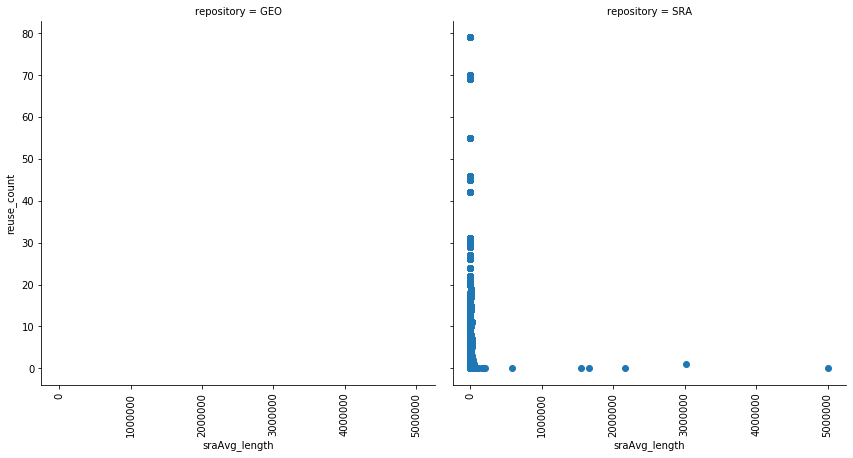

In [25]:
g = sns.FacetGrid(accs_feat, col = 'repository', height = 6)
g.map(plt.scatter, 'sraAvg_length', 'reuse_count')
g.set_xticklabels(rotation = 90)


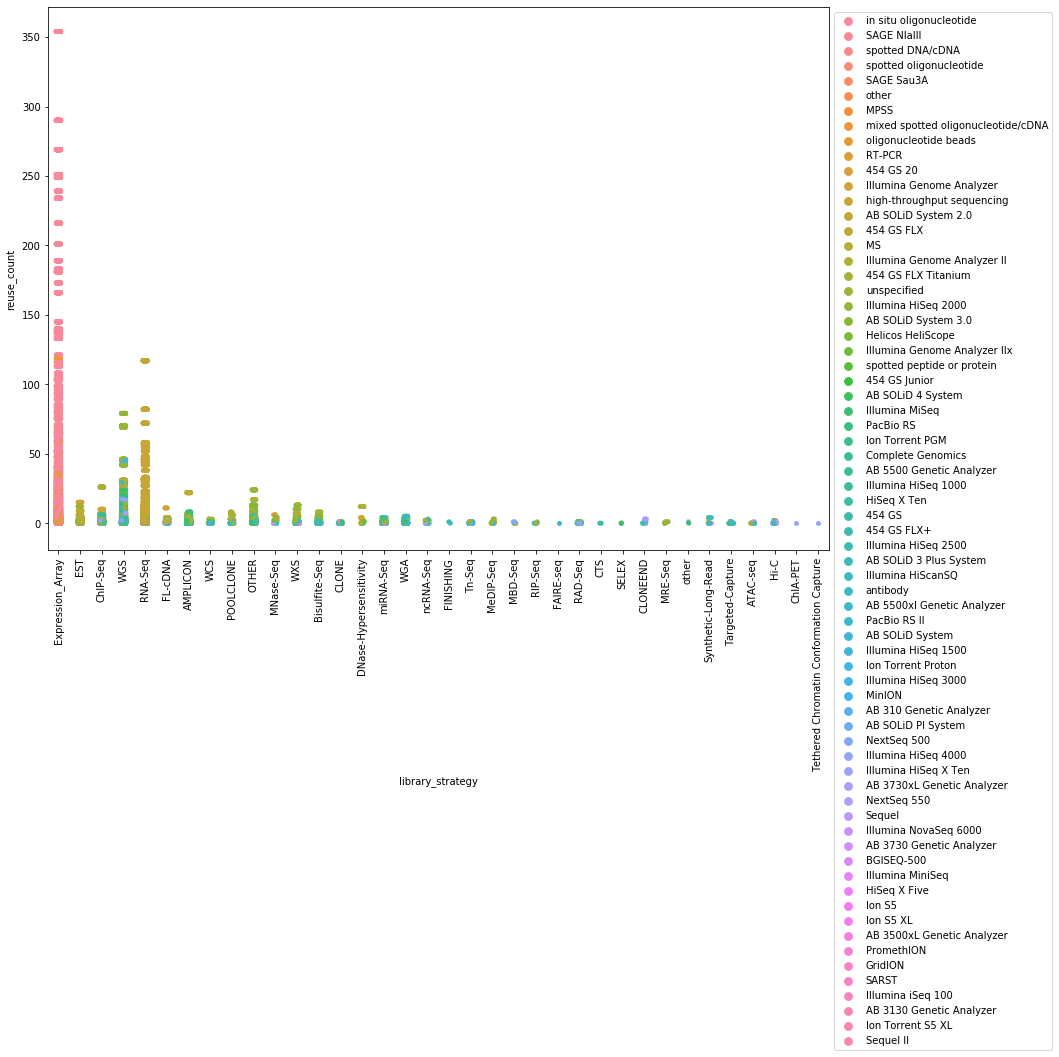

In [26]:
# plot reuse per library strategy - strip plot
fig, ax = plt.subplots(figsize=[14, 10])
s = sns.stripplot(data = accs_feat, x = 'library_strategy', y = 'reuse_count', hue = 'hardware', ax = ax)
#s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

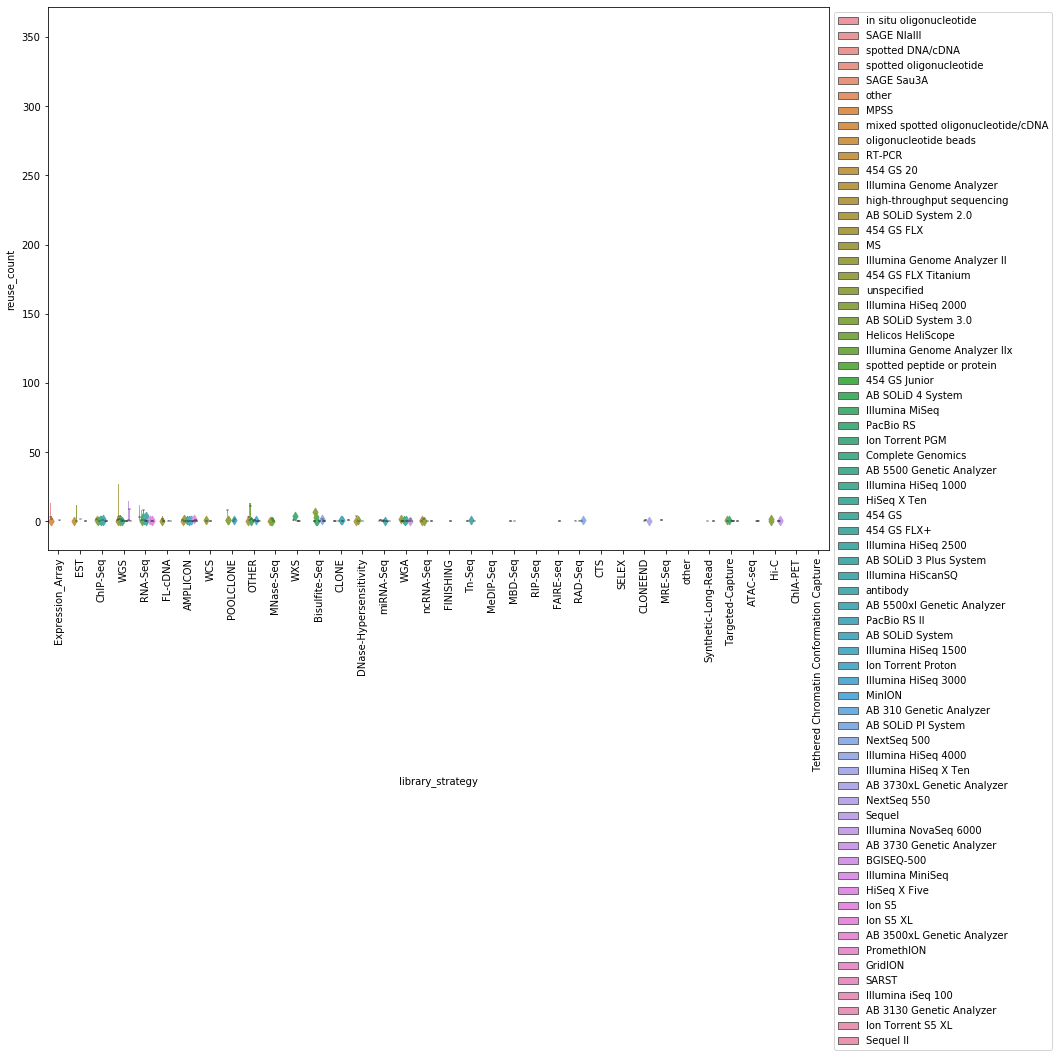

In [27]:
# plot reuse per library strategy - boxen plot
fig, ax = plt.subplots(figsize=[14, 10])
s = sns.boxenplot(data = accs_feat, x = 'library_strategy', y = 'reuse_count', hue = 'hardware', ax = ax)
# s.set(yscale = 'log')
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))
plt.show()

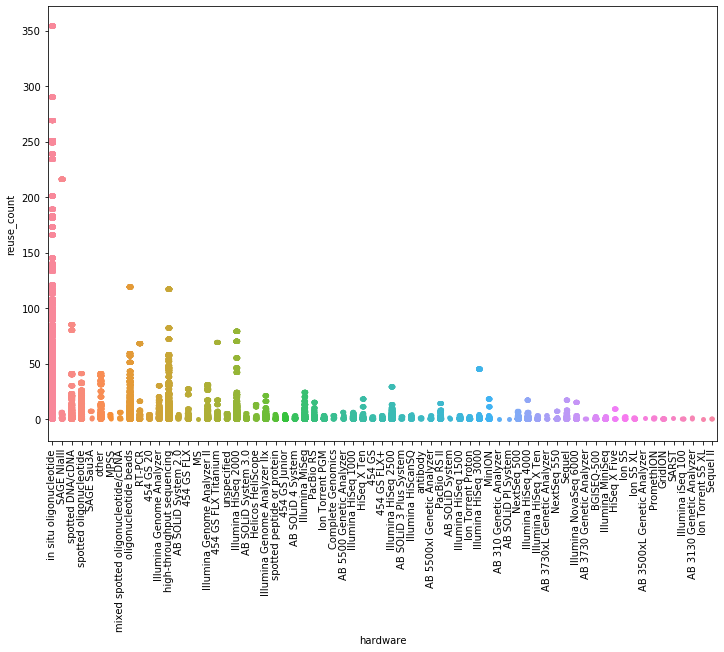

In [28]:
# plot reuse per hardware
fig, ax = plt.subplots(figsize=fig_dims)
s = sns.stripplot(data = accs_feat, x = 'hardware', y = 'reuse_count', ax = ax)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

In [29]:
# plot reuse per species

# topSpec = 


# fig, ax = plt.subplots(figsize=[18, 12])
# s = sns.stripplot(data = accs_feat, x = 'species', y = 'reuse_count', ax = ax)
# s.set_xticklabels(s.get_xticklabels(), rotation = 90)
# plt.show()